In [845]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [846]:
df= pd.read_csv('penguins.csv')

In [847]:
df.head()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
3,NaN,NaN,NaN,NaN,0
4,36.7,19.3,193.0,3450.0,0


In [848]:
df.isnull().sum()

CulmenLength     2
CulmenDepth      2
FlipperLength    2
BodyMass         2
Species          0
dtype: int64

In [849]:
X=df.drop(['Species'],axis=1).copy()
y=df['Species'].copy()

In [850]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,stratify=y)

In [851]:
used_features=['CulmenLength', 'CulmenDepth', 'FlipperLength', 'BodyMass']

In [852]:
used_features

['CulmenLength', 'CulmenDepth', 'FlipperLength', 'BodyMass']

In [853]:
#metryki
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score'])
def show_stats(model_name,model_predictions):
    cm=confusion_matrix(y_test,model_predictions)
    ax=sns.heatmap(cm,annot=True,fmt='.0f')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.show()
    
    print(model_name.upper(),'\n\n')
    print(classification_report(y_test, model_predictions))
    
    global metrics_dataframe
    f1_metric =f1_score(y_test,model_predictions,average='weighted')
    metrics_dataframe=metrics_dataframe._append({'Model':model_name,'F1_score':f1_metric},ignore_index=True)
    
    display( metrics_dataframe.sort_values(by='F1_score',ascending=False))

In [854]:
num_prep=Pipeline(steps=[('imput_missing',SimpleImputer(strategy='mean')),
                        ('standardization',StandardScaler())])

In [855]:
model_v1=Pipeline(steps=[('preprocessing',num_prep),('classifier',LogisticRegression(max_iter=1000))])

In [856]:
model_v1.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('imput_missing', SimpleImputer()),
                                 ('standardization', StandardScaler())])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [857]:
predictions_1=model_v1.predict(X_test)

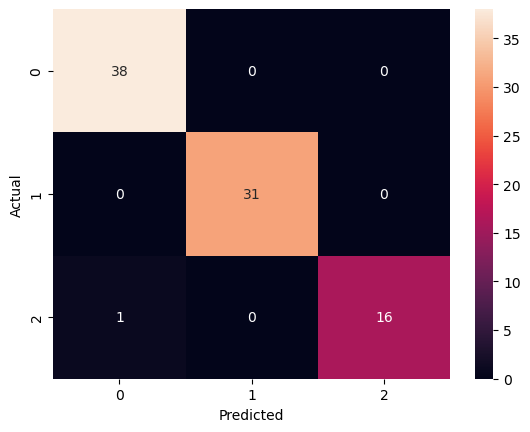

LOGISTIC REGRESSION WITH PIPELINE 


              precision    recall  f1-score   support

           0       0.97      1.00      0.99        38
           1       1.00      1.00      1.00        31
           2       1.00      0.94      0.97        17

    accuracy                           0.99        86
   macro avg       0.99      0.98      0.99        86
weighted avg       0.99      0.99      0.99        86



,Model,F1_score
0,Logistic Regression with pipeline,0.988271


In [858]:
show_stats('Logistic Regression with pipeline',predictions_1)

In [859]:
X_test_2=X_test.copy()

In [860]:
columns=list(X_test_2.columns)

In [861]:
X_test_2[columns]=X_test_2[columns].fillna(X_test_2[columns].mean())

In [862]:
X_test_2.isnull().sum()

CulmenLength     0
CulmenDepth      0
FlipperLength    0
BodyMass         0
dtype: int64

In [863]:
X_test_2_scaled=StandardScaler().fit_transform(X_test_2)

In [864]:
# importowanie poprzedniego modelu i porównanie do aktualnego

In [865]:
import joblib
lr_no_pipeline=joblib.load('lr_no_pipeline.pkl') 

In [866]:
lr_no_pipeline.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=0.1, penalty='l1', solver='liblinear')>

In [867]:
predictions_2=lr_no_pipeline.predict(X_test_2_scaled)

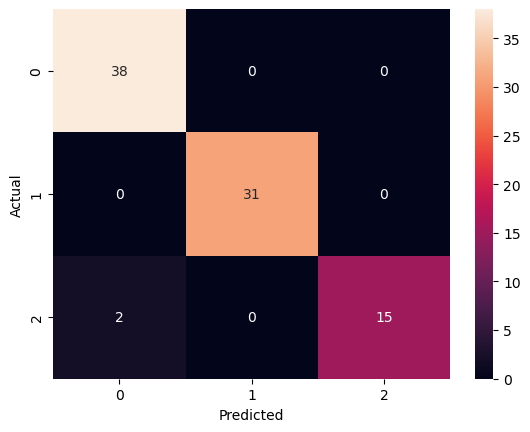

LOGISTIC REGRESSION WITHOUT PIPELINE 


              precision    recall  f1-score   support

           0       0.95      1.00      0.97        38
           1       1.00      1.00      1.00        31
           2       1.00      0.88      0.94        17

    accuracy                           0.98        86
   macro avg       0.98      0.96      0.97        86
weighted avg       0.98      0.98      0.98        86



,Model,F1_score
0,Logistic Regression with pipeline,0.988271
1,Logistic Regression without pipeline,0.976316


In [868]:
show_stats('Logistic Regression without pipeline',predictions_2)

In [869]:
# tunning hypers

In [870]:
list(model_v1.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocessing',
 'classifier',
 'preprocessing__memory',
 'preprocessing__steps',
 'preprocessing__verbose',
 'preprocessing__imput_missing',
 'preprocessing__standardization',
 'preprocessing__imput_missing__add_indicator',
 'preprocessing__imput_missing__copy',
 'preprocessing__imput_missing__fill_value',
 'preprocessing__imput_missing__keep_empty_features',
 'preprocessing__imput_missing__missing_values',
 'preprocessing__imput_missing__strategy',
 'preprocessing__standardization__copy',
 'preprocessing__standardization__with_mean',
 'preprocessing__standardization__with_std',
 'classifier__C',
 'classifier__class_weight',
 'classifier__dual',
 'classifier__fit_intercept',
 'classifier__intercept_scaling',
 'classifier__l1_ratio',
 'classifier__max_iter',
 'classifier__multi_class',
 'classifier__n_jobs',
 'classifier__penalty',
 'classifier__random_state',
 'classifier__solver',
 'classifier__tol',
 'classifier__verbose',
 'classifier__warm_start'

In [871]:
params={'preprocessing__imput_missing__strategy':['mean','median'],
       'classifier__C':np.logspace(0.1,20,50),
       'classifier__penalty':['l1', 'l2', 'elasticnet'],
       }

In [872]:
grid=GridSearchCV(model_v1,params,scoring='f1_macro',cv=10,n_jobs=-1,)

In [873]:
grid.fit(X_train,y_train)
print('Best params:', grid.best_params_)

Best params: {'classifier__C': 53.02611335911987, 'classifier__penalty': 'l2', 'preprocessing__imput_missing__strategy': 'mean'}


In [874]:
model_hyped=grid.best_estimator_

In [875]:
predictions_3=model_hyped.predict(X_test)

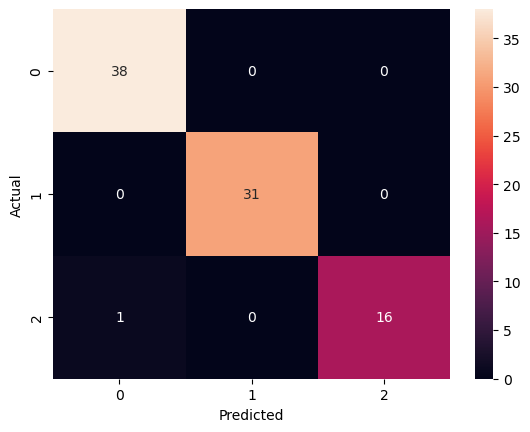

LOGISTIC REGRESSION TUNNED PARAMS 


              precision    recall  f1-score   support

           0       0.97      1.00      0.99        38
           1       1.00      1.00      1.00        31
           2       1.00      0.94      0.97        17

    accuracy                           0.99        86
   macro avg       0.99      0.98      0.99        86
weighted avg       0.99      0.99      0.99        86



,Model,F1_score
0,Logistic Regression with pipeline,0.988271
2,Logistic Regression tunned params,0.988271
1,Logistic Regression without pipeline,0.976316


In [876]:
show_stats('Logistic Regression tunned params',predictions_3)